<a href="https://colab.research.google.com/github/Bigulac/MOAR-Dense_network/blob/main/MOAR_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Потпуно повезана неурална мрежа

In [1]:
import os
import numpy as np
import keras
from keras import layers
from keras import ops
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
# Skida dataset sa interneta
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

# Izbacuje loše slike
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Obrisano {num_skipped} slika.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  58.5M      0  0:00:13  0:00:13 --:--:-- 62.7M
Obrisano 1590 slika.


In [3]:
image_size = (180, 180)
batch_size = 128

# Pravi skup slika za treninranje modela i validaciju
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
'''
# Prikaz slika iz dataseta
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title("Pas" if int(labels[i]) else "Mačka")
        plt.axis("off")
'''
# Povećanje skupa malim modifikacijama postojećih slika
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images
'''
# Prikaz kako izgledaju slike nakon modifikacija
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
'''
# Primena gornje funkcije na trening skup
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


**Одавде се код разликује.**

# Пример неуралне мреже са потпуно повезаним слојевима.
Дати су примери са различитом дубином и ширином.
На крају је изведен закључак на основу приказане ефикасности модела.

 **Модел дубоке мреже**

In [ ]:
inputs = keras.Input(shape=image_size + (3,))

# inputs.shape

x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)
'''
dense = layers.Dense(64, activation="relu")
x = dense(inputs)'''

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_deep_10 = keras.Model(inputs=inputs, outputs=outputs, name="deep_dense_model")

model_deep_10.summary()

# keras.utils.plot_model(model, show_shapes=True)


Model: "deep_dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │      12,441,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,534,657 (47.82 MB)

 Trainable params: 12,534,657 (47.82 MB)

 Non-trainable params: 0 (0.00 B)

Тренирање модела:

In [ ]:
epochs = 10

model_deep_10.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_deep_10 = model_deep_10.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.5132 - loss: 0.8794 - val_accuracy: 0.5972 - val_loss: 0.6696
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.5488 - loss: 0.6865 - val_accuracy: 0.6091 - val_loss: 0.6588
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.5677 - loss: 0.6828 - val_accuracy: 0.6160 - val_loss: 0.6575
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.5840 - loss: 0.6703 - val_accuracy: 0.6356 - val_loss: 0.6446
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5933 - loss: 0.6654 - val_accuracy: 0.6155 - val_loss: 0.6488
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5981 - loss: 0.6626 - val_accuracy: 0.6333 - val_loss: 0.6360
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.6153 - loss: 0.6546 - val_accuracy: 0.6414 - val_loss: 0.6283
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.6103 - loss: 0.6533 - val_accu

График зависности прецизности модела од броја епоха

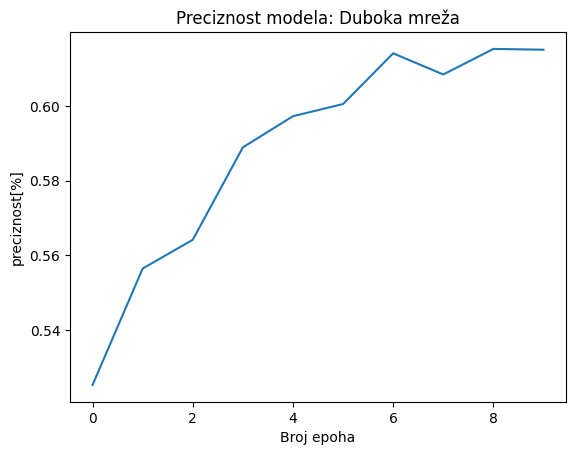

In [ ]:
plt.plot(history_deep_10.history['accuracy'])
plt.title('Preciznost modela: Duboka mreža')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()

# Други потпуно повезани модели


Napraviti da pravljenje modela bude funkcija kako bi mogao da napraviš
više modela sa različitim brojem epoha

**Модел широке мреже**

In [ ]:
inputs = keras.Input(shape=image_size + (3,))

x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_wide_10 = keras.Model(inputs=inputs, outputs=outputs, name="wide_dense_model")

model_wide_10.summary()

epochs = 10

model_wide_10.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_wide_10 = model_wide_10.fit(train_ds, validation_data=val_ds, epochs=epochs)

Model: "wide_dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2048)                │     199,067,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,493,505 (783.90 MB)

 Trainable params: 205,493,505 (783.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1048s 7s/step - accuracy: 0.5181 - loss: 11.1246 - val_accuracy: 0.5716 - val_loss: 0.6964
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 978s 7s/step - accuracy: 0.5735 - loss: 0.6813 - val_accuracy: 0.5957 - val_loss: 0.6593
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1055s 7s/step - accuracy: 0.5888 - loss: 0.6722 - val_accuracy: 0.6249 - val_loss: 0.6494
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1055s 7s/step - accuracy: 0.5912 - loss: 0.6681 - val_accuracy: 0.6403 - val_loss: 0.6362
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 996s 7s/step - accuracy: 0.6026 - loss: 0.6592 - val_accuracy: 0.6194 - val_loss: 0.6599
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1028s 7s/step - accuracy: 0.5897 - loss: 0.6651 - val_accuracy: 0.5889 - val_loss: 0.6594
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1035s 7s/step - accuracy: 0.5869 - loss: 0.6674 - val_accuracy: 0.6100 - val_loss: 0.6572
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1004s 7s/step - accuracy: 0.6017 - loss: 0.6555 - v

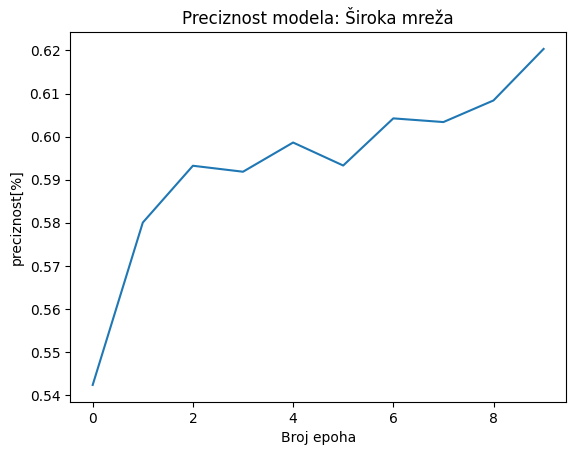

In [ ]:
plt.plot(history_wide_10.history['accuracy'])
plt.title('Preciznost modela: Široka mreža')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()


**Дубоки модел са више епоха - 25**

In [ ]:
epochs = 25

model_deep_25 = model_deep_10

model_deep_25.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_deep_25 = model_deep_25.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5917 - loss: 0.6642 - val_accuracy: 0.6245 - val_loss: 0.6378
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.6095 - loss: 0.6502 - val_accuracy: 0.6352 - val_loss: 0.6580
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.6172 - loss: 0.6486 - val_accuracy: 0.6416 - val_loss: 0.6254
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6214 - loss: 0.6455 - val_accuracy: 0.5762 - val_loss: 0.6716
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6146 - loss: 0.6531 - val_accuracy: 0.6309 - val_loss: 0.6323
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6271 - loss: 0.6453 - val_accuracy: 0.6452 - val_loss: 0.6293
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.6237 - loss: 0.6426 - val_accuracy: 0.6501 - val_loss: 0.6223
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.6271 - loss: 0.6371 - val_accu

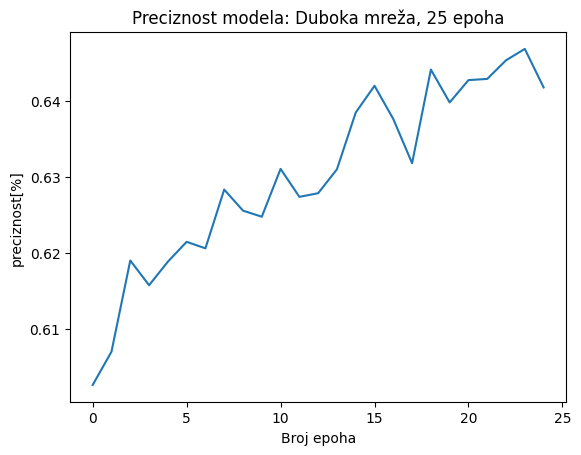

In [ ]:
plt.plot(history_deep_25.history['accuracy'])
plt.title('Preciznost modela: Duboka mreža, 25 epoha')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()

Коментар, оставити и са софтмакс функцијом, да се вдии значај активационих функција.

Додати дропаут у неку мрежу, можда му помогне


In [4]:
inputs = keras.Input(shape=image_size + (3,))

x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.BatchNormalization()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_deep_10_dropout = keras.Model(inputs=inputs, outputs=outputs, name="deep_dense_model")

model_deep_10_dropout.summary()

Model: "deep_dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,441,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │              

 Total params: 12,537,601 (47.83 MB)

 Trainable params: 12,536,129 (47.82 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
epochs = 10

model_deep_10_dropout.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_deep_10_dropout = model_deep_10_dropout.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5063 - loss: 0.8129 - val_accuracy: 0.5271 - val_loss: 0.6935
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5224 - loss: 0.7145 - val_accuracy: 0.5483 - val_loss: 0.6853
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.5314 - loss: 0.7019 - val_accuracy: 0.5713 - val_loss: 0.6794
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.5384 - loss: 0.6945 - val_accuracy: 0.5171 - val_loss: 0.7112
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5548 - loss: 0.6880 - val_accuracy: 0.5269 - val_loss: 0.7033
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.5583 - loss: 0.6820 - val_accuracy: 0.5273 - val_loss: 0.6987
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.5756 - loss: 0.6775 - val_accuracy: 0.4957 - val_loss: 0.8600
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.5764 - loss: 0.6765 - val_accu

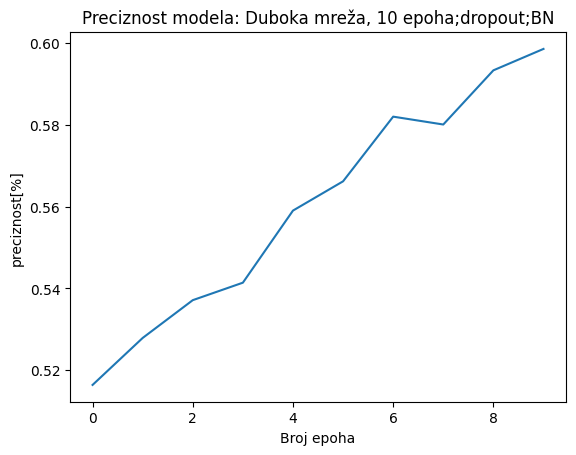

In [ ]:
plt.plot(history_deep_10_dropout.history['accuracy'])
plt.title('Preciznost modela: Duboka mreža, 10 epoha;dropout;BN')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()

Сад са 25 и 50 епоха, можда му помогне


In [5]:
model_deep_25_dropout = model_deep_10_dropout
model_deep_50_dropout = model_deep_10_dropout

Тренирање у 25 епоха

In [6]:
epochs = 25

model_deep_25_dropout.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_deep_25_dropout = model_deep_25_dropout.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.5114 - loss: 0.7851 - val_accuracy: 0.5079 - val_loss: 0.6962
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.5196 - loss: 0.7128 - val_accuracy: 0.5384 - val_loss: 0.6911
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.5382 - loss: 0.6956 - val_accuracy: 0.5748 - val_loss: 0.6785
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.5425 - loss: 0.6899 - val_accuracy: 0.5664 - val_loss: 0.6793
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.5646 - loss: 0.6828 - val_accuracy: 0.5762 - val_loss: 0.6816
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.5658 - loss: 0.6798 - val_accuracy: 0.6032 - val_loss: 0.6635
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.5737 - loss: 0.6766 - val_accuracy: 0.5897 - val_loss: 0.6705
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5781 - loss: 0.6732 - val_accu

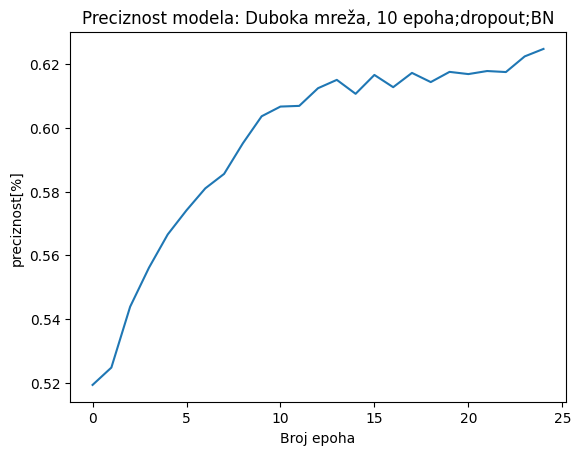

In [8]:
plt.plot(history_deep_25_dropout.history['accuracy'])
plt.title('Preciznost modela: Duboka mreža, 10 epoha;dropout;BN')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()

Тренирање у 50 епоха

In [9]:
epochs = 50

model_deep_50_dropout.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_deep_50_dropout = model_deep_50_dropout.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6083 - loss: 0.6528 - val_accuracy: 0.6126 - val_loss: 0.6432
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6145 - loss: 0.6469 - val_accuracy: 0.6393 - val_loss: 0.6337
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6213 - loss: 0.6446 - val_accuracy: 0.5316 - val_loss: 0.7898
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.6210 - loss: 0.6423 - val_accuracy: 0.4977 - val_loss: 0.7958
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.6219 - loss: 0.6459 - val_accuracy: 0.5553 - val_loss: 0.6849
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.6190 - loss: 0.6469 - val_accuracy: 0.6264 - val_loss: 0.6365
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.6209 - loss: 0.6431 - val_accuracy: 0.5030 - val_loss: 0.7709
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6180 - loss: 0.6453 - val_accu

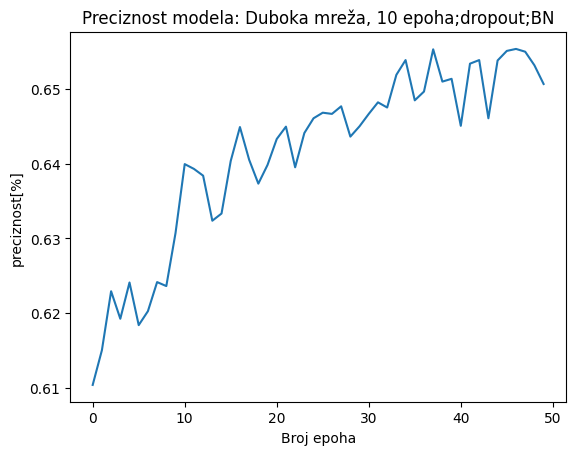

In [10]:
plt.plot(history_deep_50_dropout.history['accuracy'])
plt.title('Preciznost modela: Duboka mreža, 10 epoha;dropout;BN')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()